### Spaceship Titanic with fastai

Competition [Link](https://www.kaggle.com/competitions/spaceship-titanic/overview)

In [1]:
#|default_exp app

In [2]:
#The Following cell of code is used everytime FASTAI library is used.
#They tell the notebook to reload any changes made to any libraries used.
#They also ensure that any graphs are plotted are shown in this notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.tabular.all import *
from fastbook import *

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder

import seaborn as sns

from dtreeviz.trees import *
import dtreeviz

from IPython.display import Image, display_svg, SVG

In [4]:
#| export
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
creds = ''

In [5]:
#| export
cred_path = Path('~/.kaggle/kaggle.json').expanduser()
if not cred_path.exists():
    cred_path.parent.mkdir(exist_ok=True)
    cred_path.write_text(creds)
    cred_path.chmod(0o600)

In [6]:
#| export
path = Path('spaceship-titanic')

In [7]:
#| export
if not iskaggle and not path.exists():
    import zipfile, kaggle
    kaggle.api.competition_download_cli(str(path))    
    zipfile.ZipFile(f'{path}.zip').extractall(path)

In [8]:
#| export
if iskaggle:
    path = Path('../input/spaceship-titanic')
    ! pip install -q dataset

Import CSV's as Pandas Dataframes

In [9]:
#| export
df = pd.read_csv(path/'train.csv', low_memory=False)
test_df = pd.read_csv(path/'test.csv', low_memory=False)
sample_df = pd.read_csv(path/'sample_submission.csv', low_memory=False)

In [10]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True


In [11]:
len(df)

8693

This name on such a small dataset could cause overfitting, so I'm going to try splitting into families by last name. I'll also be dropping `Name` as a category afterward

In [12]:
df['surname'] = df['Name'].str.split(' ').str[1]

In [13]:
df = df.drop(['Name'], axis=1)

Looking at this there's some extra data we can extract to new columns, *PassengerId* looks like it's by group number and the number in a particular group, split with an underscore `_` 

In [14]:
df['group_num'] = df['PassengerId'].str.split('_').str[0]
df['num_w_in_group'] = df['PassengerId'].str.split('_').str[1]

The same is true for the Cabin, there are 3 different values to analyze here, so let's split them up as well

In [15]:
df['deck'] = df['Cabin'].str.split('/').str[0]
df['room_num'] = df['Cabin'].str.split('/').str[1]
df['side'] = df['Cabin'].str.split('/').str[2]

In [16]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,group_num,num_w_in_group,deck,room_num,side
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Ofracculy,0001,01,B,0,P
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Vines,0002,01,F,0,S
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Susent,0003,01,A,0,S
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Susent,0003,02,A,0,S
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Santantines,0004,01,F,1,S


Take the max number of the last two digits in PassengerId given that the first four numbers are the same

In [17]:
df['num_w_in_group'] = df['num_w_in_group'].astype(int)

In [18]:
max_num_in_group = df.groupby('group_num')['num_w_in_group'].max().astype(int)

In [19]:
len(max_num_in_group)

6217

In [20]:
max_num_in_group.head()

group_num
0001    1
0002    1
0003    2
0004    1
0005    1
Name: num_w_in_group, dtype: int64

In [21]:
df['num_in_group'] = df['group_num'].map(max_num_in_group)

In [22]:
df.head()

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,group_num,num_w_in_group,deck,room_num,side,num_in_group
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Ofracculy,0001,1,B,0,P,1
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Vines,0002,1,F,0,S,1
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Susent,0003,1,A,0,S,2
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Susent,0003,2,A,0,S,2
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Santantines,0004,1,F,1,S,1


Finding if everyone boarding is a family group or not by last name:
- Find if the count of family group == num_in_group

In [23]:
boarded_together = df.groupby('surname')['num_in_group'].nunique() == 1

In [24]:
df['fam_board_together'] = df['surname'].map(boarded_together)

In [25]:
df.head(n=30)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,surname,group_num,num_w_in_group,deck,room_num,side,num_in_group,fam_board_together
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,False,Ofracculy,0001,1,B,0,P,1,True
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,True,Vines,0002,1,F,0,S,1,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,False,Susent,0003,1,A,0,S,2,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,False,Susent,0003,2,A,0,S,2,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,True,Santantines,0004,1,F,1,S,1,False
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,True,Hinetthews,0005,1,F,0,P,1,False
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,True,Jacostaffey,0006,1,F,2,S,2,False
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,True,Jacostaffey,0006,2,G,0,S,2,False
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,True,Beston,0007,1,F,3,S,1,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,True,Flatic,0008,1,B,1,P,3,True


In [27]:
def get_null_counts(df):
    null_count_df = pd.DataFrame((df.isnull().sum()).sort_values(ascending=False).reset_index())
    null_count_df.columns = ['column_name','null_counts']
    null_count_df = null_count_df.query("column_name!='Transported'")
    return null_count_df

null_= get_null_counts(df)
null_.style.background_gradient(cmap='summer')

,column_name,null_counts
0,CryoSleep,217
1,ShoppingMall,208
2,VIP,203
3,HomePlanet,201
4,fam_board_together,200
5,surname,200
6,Cabin,199
7,side,199
8,room_num,199
9,deck,199


Boolean values converted to 0's and 1's

In [29]:
def bool_switch(df, col_name):
    encoder = LabelEncoder()
    df[f'{col_name}'] = encoder.fit_transform(df[f'{col_name}']) 

In [30]:
bool_switch(df, col_name='Transported')
bool_switch(df, col_name='VIP')
bool_switch(df, col_name='CryoSleep')

### Preparing Data

Declare dependant variable(y-axis)

In [31]:
#| export
dep_var = 'Transported'

In [32]:
df['Destination'].sample

<bound method NDFrame.sample of 0         TRAPPIST-1e
1         TRAPPIST-1e
2         TRAPPIST-1e
3         TRAPPIST-1e
4         TRAPPIST-1e
            ...      
8688      55 Cancri e
8689    PSO J318.5-22
8690      TRAPPIST-1e
8691      55 Cancri e
8692      TRAPPIST-1e
Name: Destination, Length: 8693, dtype: object>

Add tabular processes to transform categorical variables to something similar to `pd.Categorical`, and fill in missing/na values

In [33]:
#| export
procs = [Categorify, FillMissing, Normalize]

In [34]:
#| export
cont, cat = cont_cat_split(df, 1, dep_var=dep_var)

In [37]:
to = TabularPandas(df, procs, cat, cont, y_names=dep_var, 
                    y_block=CategoryBlock(), 
                    splits=RandomSplitter(valid_pct=0.2, seed=42)(df)).dataloaders(bs=128)

In [38]:
xs, y = to.train.xs, to.train.y
valid_xs, valid_y = to.valid.xs, to.valid.y

/tmp/ipykernel_26957/3888966817.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


<AxesSubplot: >

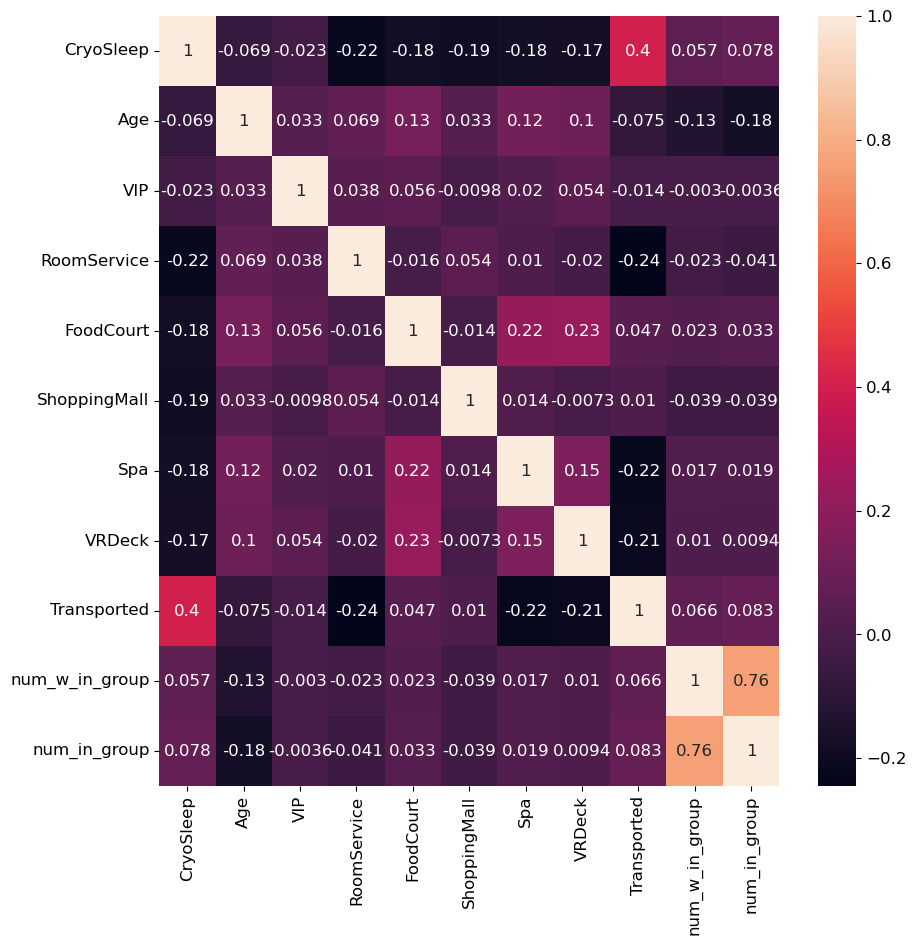

In [39]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(), annot=True)

In [40]:
def rf(xs, y, n_estimators=40, max_features=0.5, min_samples_leaf=5, **kwargs):
    return RandomForestClassifier(n_jobs=-1, n_estimators=n_estimators,
        max_features=max_features, min_samples_leaf=min_samples_leaf, 
        oob_score=True).fit(xs,y)

In [41]:
m = rf(xs,y)

In [42]:
def pred_acc(m, valid_xs=valid_xs):
    y_pred = m.predict(valid_xs)
    accuracy = accuracy_score(valid_y, y_pred)
    return accuracy

In [43]:
pred_acc(m)

0.8072497123130035

In [44]:
def rf_feat_importances(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}).sort_values('imp', ascending=False)

In [45]:
fi = rf_feat_importances(m, xs)
fi

,cols,imp
16,CryoSleep,0.212583
22,Spa,0.090482
23,VRDeck,0.088863
19,RoomService,0.078226
2,Cabin,0.072802
20,FoodCourt,0.068224
17,Age,0.060515
21,ShoppingMall,0.049305
7,room_num,0.047880
4,surname,0.044987
